In [247]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [248]:
with open("upanishads.txt", "r") as f:
    text = f.read()

In [249]:
text = text.lower()
text = ' '.join(text.split())

In [250]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
itos = {i:c for i,c in enumerate(chars)}
stoi = {c:i for i,c in enumerate(chars)}
encode = lambda s : [stoi[c] for c in s]
decode = lambda l : ''.join([itos[i] for i in l])
print(decode(encode("hello")))

hello


In [251]:
print([(c, text.count(c)) for c in chars])

[(' ', 94773), ('!', 403), ('"', 2768), ("'", 269), ('(', 857), (')', 858), (',', 7524), ('.', 5451), ('0', 83), ('1', 647), ('2', 409), ('3', 246), ('4', 215), ('5', 152), ('6', 146), ('7', 112), ('8', 112), ('9', 96), (':', 863), (';', 868), ('?', 363), ('a', 36360), ('b', 6840), ('c', 7846), ('d', 15800), ('e', 52576), ('f', 10301), ('g', 6914), ('h', 31402), ('i', 30626), ('j', 1075), ('k', 3250), ('l', 13690), ('m', 10293), ('n', 26957), ('o', 28010), ('p', 6065), ('q', 250), ('r', 24194), ('s', 29255), ('t', 39054), ('u', 9034), ('v', 4789), ('w', 8122), ('x', 579), ('y', 7013), ('z', 103), ('—', 1268)]


In [252]:
data = torch.tensor(encode(text), dtype=torch.long, device='cuda')

In [253]:
n = int(0.9*len(data))
train, test = data[:n], data[n:]

In [254]:
len(train), len(test)

(475992, 52889)

In [255]:
batch_size = 32
window_length = 8

def get_batch(split):
    data = train if split == 'train' else test
    ix = torch.randint(len(data) - window_length, (batch_size,))
    x = torch.stack([data[i:i+window_length] for i in ix])
    y = torch.stack([data[i+1:i+window_length+1] for i in ix])
    return x, y

In [256]:
x, y = get_batch(train)
for i in range(batch_size):
    for j in range(window_length):
        print(f"When input is {x[i,:j+1].tolist()}, output is {y[i,j]}")

When input is [29], output is 23
When input is [29, 23], output is 39
When input is [29, 23, 39], output is 6
When input is [29, 23, 39, 6], output is 0
When input is [29, 23, 39, 6, 0], output is 25
When input is [29, 23, 39, 6, 0, 25], output is 40
When input is [29, 23, 39, 6, 0, 25, 40], output is 45
When input is [29, 23, 39, 6, 0, 25, 40, 45], output is 33
When input is [26], output is 32
When input is [26, 32], output is 25
When input is [26, 32, 25], output is 23
When input is [26, 32, 25, 23], output is 40
When input is [26, 32, 25, 23, 40], output is 29
When input is [26, 32, 25, 23, 40, 29], output is 35
When input is [26, 32, 25, 23, 40, 29, 35], output is 34
When input is [26, 32, 25, 23, 40, 29, 35, 34], output is 0
When input is [34], output is 25
When input is [34, 25], output is 0
When input is [34, 25, 0], output is 38
When input is [34, 25, 0, 38], output is 25
When input is [34, 25, 0, 38, 25], output is 26
When input is [34, 25, 0, 38, 25, 26], output is 32
When in

In [257]:
class BigramModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x, y=None):
        #shape of x and y is B, W
        logits = self.table(x) #shape is B, W, E
        if y is None:
            loss = None
        else:
            B, W, E = logits.shape
            loss = F.cross_entropy(logits.view(B*W, E), y.view(B*W))
        return logits, loss
    
    def generate(self, x, length):
        #x is a single character index
        generated = []
        for _ in range(length):
            logits, loss = self(x) #logits is B,W,E
            logits = logits[:, -1, :] #get the newly predicted word only.
            probs = F.softmax(logits, dim=1)
            idx = probs.multinomial(1)
            generated.append(idx.item())
        return generated

In [258]:
model = BigramModel(vocab_size).to('cuda')

In [279]:
prompt = "brahman is"
prompt_tensor = torch.tensor(encode(prompt), device='cuda').reshape(1,-1)
generated = model.generate(prompt_tensor, 50)
print(prompt + "_" + decode(generated))

brahman is_tesa  dp,bpt s ah tp   aauetuo  kse hh —— cei  as 


In [269]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
losses = []
n_epochs = 2000
for i in range(n_epochs):
    x, y = get_batch("train")
    logits, loss = model(x, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())    

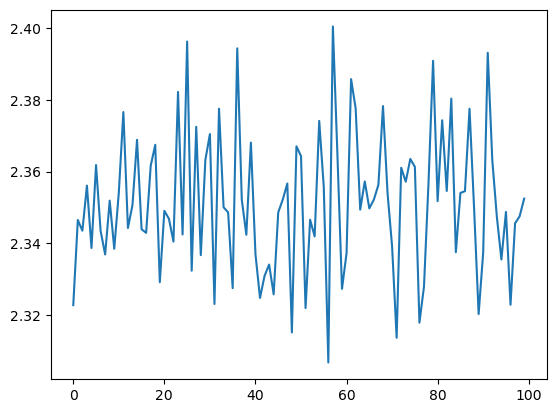

In [270]:
plt.plot([np.mean(losses[i:i+20]) for i in range(0, len(losses), 20)])